In [ ]:
import re
import os
import io
import sys
import random
import warnings
import importlib
import numpy as np
import tf_functions
import pandas as pd
import pickle as pkl
import seaborn as sns
import transformer_v2
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import time

from numba import cuda
from PIL import Image
from collections import Counter
from sklearn import preprocessing
from nltk.corpus import stopwords
from tensorflow.keras import mixed_precision
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

importlib.reload(tf_functions)

VitModel = transformer_v2.VitModel
ViClassifier = tf_functions.ViClassifier

warnings.filterwarnings('ignore')
mixed_precision.set_global_policy('mixed_float16')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

### PATHS
VERSION_DS = 1
TF_RECORD_PATH = '../Data/dataset.tfrecord'
DATASET_PATH = '../Bases de Datos/CrisisMMD_v2.0/data_image/' if VERSION_DS == 1 else '../Bases de Datos/Cyclone_Wildfire_Flood_Earthquake_Database/'

### Utils functions

In [ ]:
re_url = re.compile(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
re_email = re.compile(r'[\w\.-]+@[\w\.-]+')
re_hashtag = re.compile(r'#([^\s]+)')

def clean_str(string):
  string = re_url.sub('', string)
  string = re.sub(r"[^A-Za-z0-9(),!?\'\#@`]", " ", string)
  string = re.sub(r"\'s", " \'s", string)
  string = re.sub(r"\'ve", " \'ve", string)
  string = re.sub(r"n\'t", " n\'t", string)
  string = re.sub(r"\'re", " \'re", string)
  string = re.sub(r"\'d", " \'d", string)
  string = re.sub(r"\'ll", " \'ll", string)
  string = re.sub(r",", " , ", string)
  string = re.sub(r"!", " ! ", string)
  string = re.sub(r"\(", " \( ", string)
  string = re.sub(r"\)", " \) ", string)
  string = re.sub(r"\?", " \? ", string)
  string = re.sub(r"\s{2,}", " ", string)
  string = string.strip().lower().split()
  string = [ word for word in string if word not in stop_words ]
  return " ".join(string)

In [ ]:
def get_class_names(ds_path):
  class_array = []
  for class_name in os.listdir(ds_path):
    class_array.append(class_name)
  return class_array

def get_class_id(class_name):
  return class_array.index(class_name)


def build_example(path_file, class_name):
  n_path = path_file
  if not path_file.endswith('.jpeg') and not path_file.endswith('.jpg'):
    img_array = Image.open(path_file).convert('RGB')
    n_path = path_file.replace('.png', '.jpeg')
    img_array.save(n_path)
    os.remove(path_file)

  path_file = n_path
  img_array = open(path_file, 'rb').read()
  example = tf.train.Example(
    features=tf.train.Features(feature={
    'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_array])),
    'class_id': tf.train.Feature(int64_list=tf.train.Int64List(value=[get_class_id(class_name)])),
    'class_name': tf.train.Feature(bytes_list=tf.train.BytesList(value=[class_name.encode('utf-8')])),
    'filepath': tf.train.Feature(bytes_list=tf.train.BytesList(value=[path_file.encode('utf-8')]))
  }))
  return example

def create_tf_record(version, ds_path, out_dir):
  writer = tf.io.TFRecordWriter(out_dir)
  print('Start writing to {}'.format(out_dir))
  if version == 1:
    for class_name in os.listdir(ds_path):
      for date in os.listdir(f'{ds_path}/{class_name}/'):
        for idx, filename in enumerate(os.listdir(f'{ds_path}/{class_name}/{date}/')):
          path_file = os.path.join(ds_path, class_name, date, filename)
          tf_example = build_example(path_file, class_name)
          writer.write(tf_example.SerializeToString())
  elif version == 2:
    for class_name in os.listdir(ds_path):
      for idx, filename in enumerate(os.listdir(f'{ds_path}/{class_name}/')):
        path_file = os.path.join(ds_path, class_name, filename)
        tf_example = build_example(path_file, class_name)
        writer.write(tf_example.SerializeToString())
  writer.close()
  print('Done')


def parse_tfrecord(tfrecord, size):
  x = tf.io.parse_single_example(tfrecord, IMAGE_FEATURE_MAP)
  x_train = tf.image.decode_jpeg(x['image'], channels=3)
  x_train = tf.image.resize(x_train, (size, size))
  x_train = preprocess_input(x_train, mode='tf')

  class_id = x['class_id']
  if class_id is None:
    class_id = -1
  y_train = tf.cast(class_id, tf.int64)

  return ( x_train, y_train )

def load_tfrecord_dataset(file_pattern, size):

  files = tf.data.Dataset.list_files(file_pattern)
  dataset = files.flat_map(tf.data.TFRecordDataset)
  dataset = dataset.map(lambda x: parse_tfrecord(x, size))
  return dataset

IMAGE_FEATURE_MAP = {
  'image': tf.io.FixedLenFeature([], tf.string),
  'class_id': tf.io.FixedLenFeature([], tf.int64),
}

class_array = get_class_names(DATASET_PATH)

In [ ]:
class_array = get_class_names(DATASET_PATH)
pkl.dump(class_array, open('../Data/class_array.pkl', 'wb'))
create_tf_record(VERSION_DS, DATASET_PATH, TF_RECORD_PATH)

In [ ]:
# VISION TRANSFORMER
SIZE_IMG = 88
LEARNING_RATE = 0.0000200 #0.0000200 0.0000100
vit_params = {
  'transformer_layers': 8,
  'patch_size': 8, 
  'projection_dim': 256,
  'num_heads': 1,
  'mlp_head_units': [ 256 ],
  'num_classes': len(class_array),
  'input_shape': (SIZE_IMG, SIZE_IMG, 3),
}
vit_params['num_patches'] = (SIZE_IMG // vit_params['patch_size']) ** 2
vit_params['transformer_units'] = [
  vit_params['projection_dim'] * 2,
  vit_params['projection_dim']
]
prefix_data = f'vit_{SIZE_IMG}'
model = VitModel(**vit_params)
params_str = '_'.join(map(str, vit_params.values()))
name = f'{prefix_data}_{len(class_array)}_{params_str}checkpoint.h5'
check_name = f'checkpoints/{name}'

In [ ]:
# CONV MODEL
SIZE_IMG = 128 # RestNet 127
EXTRACTOR_MODEL = 'resnet'
LEARNING_RATE = 0.000100
conv_params = {
  'num_classes': len(class_array),
  'input_shape': (SIZE_IMG, SIZE_IMG, 3),
  'type_extractor': EXTRACTOR_MODEL,
  'units': 1024,
  'inner_layers': 3
}
prefix_data = f'{EXTRACTOR_MODEL}_{SIZE_IMG}'
params_str = '_'.join(map(str, conv_params.values()))
name = f'{prefix_data}_{len(class_array)}_{params_str}checkpoint.h5'
check_name = f'checkpoints/{name}'
model = ViClassifier(**conv_params)

In [ ]:
class_array = pkl.load(open('../Data/class_array.pkl', 'rb'))
tf_record = load_tfrecord_dataset(TF_RECORD_PATH, SIZE_IMG)
tf_record = tf_record.cache()

all_ds_len = sum(1 for _ in tf_record)
tf_record = tf_record.shuffle(all_ds_len, seed=SEED)
print(f'Total number of images: {all_ds_len}')

n_train = int(all_ds_len * 0.8)
n_valid = int(all_ds_len * 0.1)
n_test = all_ds_len - n_train - n_valid

train_ds = tf_record.take(n_train)
valid_ds = tf_record.skip(n_train).take(n_valid)
test_ds = tf_record.skip(n_train + n_valid).take(n_test)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
input_shape = (None, SIZE_IMG, SIZE_IMG, 3)
model.build(input_shape)

logdir = "./logs/" + prefix_data + "/" + time.strftime("%Y%m%d_%H-%M-%S")
callbacks = [
  ReduceLROnPlateau(verbose=1),
  #EarlyStopping(patience=10, verbose=1),
  ModelCheckpoint(
    check_name,
    verbose=1,
    monitor='accuracy',
    save_freq='epoch',
    save_best_only=True,
    save_weights_only=True,
  ),
  TensorBoard(log_dir=logdir, histogram_freq=1)
]
model.compile(
  loss=loss,
  optimizer=optimizer,
  metrics=[
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    #tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
  ],
)
BATCH = 64
EPOCHS = 200
model.fit(
  epochs=EPOCHS,
  callbacks=callbacks,
  x=train_ds.batch(BATCH),
  validation_data=valid_ds.batch(BATCH)
)

In [ ]:
output = model.evaluate(train_ds.batch(BATCH))

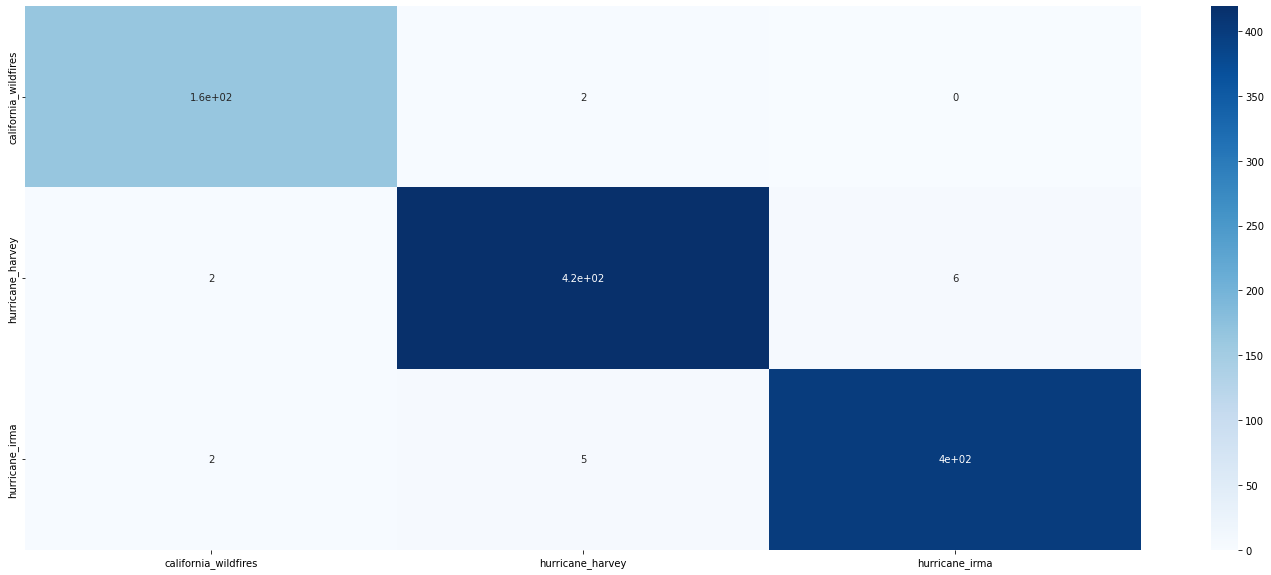

In [7]:
tf_record_eva = test_ds.batch(256)

all_preds = []
all_labels = []
for images, label in tf_record_eva:
  preds = model.predict(images)
  all_labels.extend(label)
  all_preds.extend(np.argmax(preds, axis=1))
del tf_record_eva

confusion_matrix = tf.math.confusion_matrix(all_labels, all_preds, num_classes=len(class_array))

plt.figure(figsize=(25, 10))
sns.heatmap(confusion_matrix.numpy(), annot=True, cmap='Blues', xticklabels=class_array, yticklabels=class_array)
plt.savefig(f'./metrics/{prefix_data}_{name}_cm.pdf')